**TITLE**: Eigen-portfolio construction with S&P 500 data  
**AUTHOR**: Pablo Carrera Flórez de Quiñones  
**DATE**: March 2020  

# INTRODUCTION

## Statement of the problem

Portfolio optimization is the process of selecting the best portfolio (asset distribution), out of the set of all portfolios being considered, according to some objective. The objective typically maximizes factors such as expected return, and minimizes costs like financial risk through a correct diversification. The usual way to test this optimal portfolio is to compare its perfomance against a well known stock index, using it as a benchmark for the possible returns. A stock index, or stock market index, is an index that measures a stock market, or a subset of the stock market, that helps investors compare current price levels with past prices to calculate market performance. It is computed from the prices of selected stocks (typically a weighted arithmetic mean).

The S&P 500 is a stock market index that comprises 505 common stocks issued by 500 large-cap companies and traded on American stock exchanges (including the 30 companies that compose the Dow Jones Industrial Average), and covers about 80 percent of the American equity market by capitalization. The index is weighted by free-float market capitalization, so more valuable companies account for relatively more of the index. The index constituents and the constituent weights are updated regularly using rules published by S&P Dow Jones Indices. Although the index is called the S&P 500, the index contains 505 stocks because it includes two share classes of stock from 5 of its component companies. The S&P 500 is maintained by S&P Dow Jones Indices, a joint venture majority-owned by S&P Global and its components are selected by a committee.

In this work, inspired by the *Machine Learning and Reinforcement Learning in Finance Specialization* of *Coursera*, we are going to study a proposal for portfolio optimization based on the construction of eigen-portfolios using Principal Component Analysis (PCA) \[1\]. This will provide a model-free factor analysis, in the sense that we do not rely on any factors such as value or momentum to decompose portfolio returns, but instead using PCA to deduce structure of portfolio returns.

## References

\[1\] Marco Avellaneda & Jeong-Hyun Lee (2010) *Statistical arbitrage in the US equities market*, Quantitative Finance, 10(7), 761-782, DOI: [10.1080/14697680903124632](https://doi.org/10.1080/14697680903124632)

\[2\] William F. Sharpe (1966) *Mutual Fund Performance*, Journal of Business, 39(1), 119–138, DOI: [10.1086/294846](https://www.jstor.org/stable/2351741).

# DATA

## Libraries

In [1]:
# Basics
import pandas as pd
import numpy as np
import random

# Domain specific
import pandas_datareader as pdr
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.decomposition import PCA

## Importing data

We are going to construct our portfolio taking into account the stocks contained into S&P 500 index, this will allow us to compare the performance of our eigen-portfolios with the performance of S&P 500 index, which is one of the most followed indicators of the market state. So, the first step in our project is to obtain the data of the daily prices of these stocks. We can obtain this data from Yahoo Finance by running the script *download_stocks_SP500.py* in *utils* folder.

In [2]:
# Import the data after running the script
df = pd.read_csv('data/SP500_stocks_2000_2019.csv', index_col = 0, parse_dates = True)

# Show a sample of the data
df.head()

MMM        ABT  ABBV      ABMD  ACN      ATVI       ADBE  \
2000-01-03  47.1875  15.711531   NaN  18.25000  NaN  1.369792  16.390625   
2000-01-04  45.3125  15.262630   NaN  17.81250  NaN  1.328125  15.015625   
2000-01-05  46.6250  15.234573   NaN  18.00000  NaN  1.333333  15.312500   
2000-01-06  50.3750  15.767643   NaN  18.03125  NaN  1.307292  15.437500   
2000-01-07  51.3750  15.935981   NaN  17.93750  NaN  1.343750  16.187500   

               AMD  AAP       AES  ...        XRX     XLNX  XYL       YUM  \
2000-01-03  15.500  NaN  36.25000  ...  63.735176  46.7500  NaN  6.706057   
2000-01-04  14.625  NaN  34.81250  ...  60.770752  45.6875  NaN  6.571262   
2000-01-05  15.000  NaN  35.18750  ...  63.899868  44.6875  NaN  6.604960   
2000-01-06  16.000  NaN  35.46875  ...  62.582344  40.8125  NaN  6.548796   
2000-01-07  16.250  NaN  36.15625  ...  64.064560  45.4375  NaN  6.402768   

                 ZBRA  ZBH     ZION  ZTS        ^GSPC  VIAC  
2000-01-03  25.027779  NaN  55.5000  NaN  1455.219971   NaN  
2000-01-04  24.666666  NaN  52.8125  NaN  1399.420044   NaN  
2000-01-05  25.138889  NaN  52.7500  NaN  1402.109985   NaN  
2000-01-06  23.777779  NaN  53.5000  NaN  1403.449951   NaN  
2000-01-07  23.513889  NaN  53.6250  NaN  1441.469971   NaN  

[5 rows x 506 columns]

Now, it is always a good idea to look for mising values at the data,

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5031 entries, 2000-01-03 to 2019-12-31
Columns: 506 entries, MMM to VIAC
dtypes: float64(506)
memory usage: 19.5 MB


so we can see that some prices have a grear quantity of missing values, this is due to the fact that they became public after the year 2000, so there are no prices below these years. Since we need all time-series to have the same lenght we are going to delete them:

In [4]:
df = df.dropna(axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5031 entries, 2000-01-03 to 2019-12-31
Columns: 364 entries, MMM to ^GSPC
dtypes: float64(364)
memory usage: 14.0 MB


And now, we can plot the historical evolution of the prices

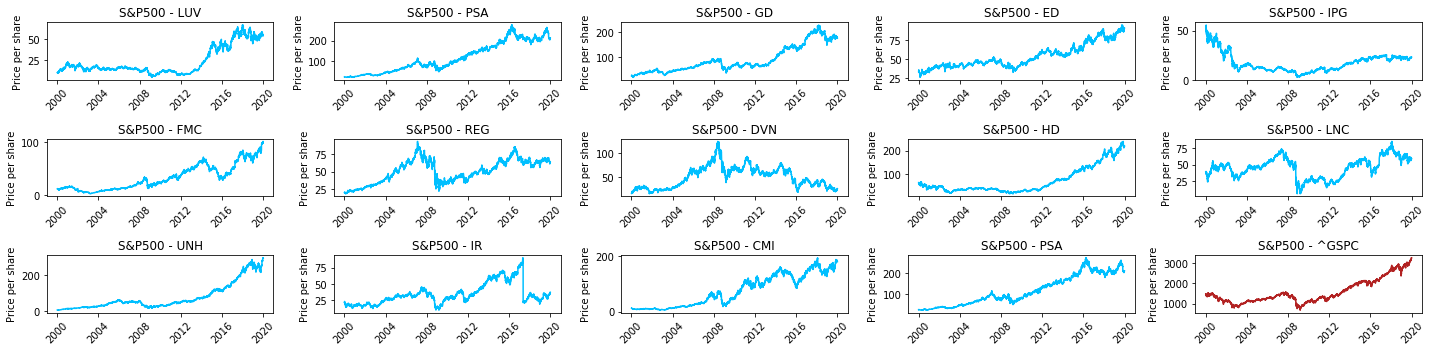

In [5]:
# Select some stocks to plot
random.seed(0)
stocks_to_plot = random.choices(df.columns.to_list(), k = 14) + ['^GSPC']

# Make the layout
n_rows = 3
n_cols = 5

plt.figure(figsize = (20,5))
for i,stock in enumerate(stocks_to_plot):
    # Choose the color
    if stock == '^GSPC':
        color = 'firebrick'
    else:
        color = 'deepskyblue'

    # Plot the stock prices
    plt.subplot(n_rows, n_cols, i + 1)
    sns.lineplot(x = df.index, y = df[stock], color = color)

    # Formatting
    plt.title('S&P500 - {}'.format(stock))
    plt.xlabel('')
    plt.ylabel('Price per share')
    plt.xticks(rotation = 45)

# Formatting
plt.tight_layout()
plt.show()

from where we can expect the series to have a high degree of autorrelation and a high degree of correlations between them and with the S&P 500 index value.

# MODELLING

## Computation of returns

It is a common practice not to analize the price series itself, but its retuns. The returns are computed as the porcentual change in the price series, that is, if the price for an asset $i$ at time $t$ is given by $p_i^{t}$ then its return will be given by

$$ r_i^t = \frac{p_i^t - p_i^{t-1}}{p_i^{t-1}} $$

and it is also common to compute the log-returns, which are simply a logarithmic version of these returns

$$ r_i^{'t} = \log \frac{p_i^t - p_i^{t-1}}{p_i^{t-1}} $$

which provide a smoother representation of the series.

Since some stocks are more volatile than others, it is convenient to work with standardized returns, that is, to substract the mean $\mu_i$ of each return and divide the residual by the return's standard deviation $\sigma_i$, given by

\begin{align*}
    & \mu_i = \frac{1}{T} \sum_{t=1}^T r_i^t \\
    & \sigma_i^2 = \frac{1}{T-1} \sum_{t=1}^T (r_i^t - \mu_i)^2 \ 
\end{align*}

so we get

$$ r_i^t = \frac{r_i^t - \mu_i}{\sigma_i} $$



In [6]:
# Compute the returns
df_returns = df.pct_change().dropna(axis = 0)

# Standarize the returns
df_mean = df_returns.mean(axis = 0)
df_volatility = df_returns.std(axis = 0)
df_stand = (df_returns - df_mean) / df_volatility

And visualizing the returns

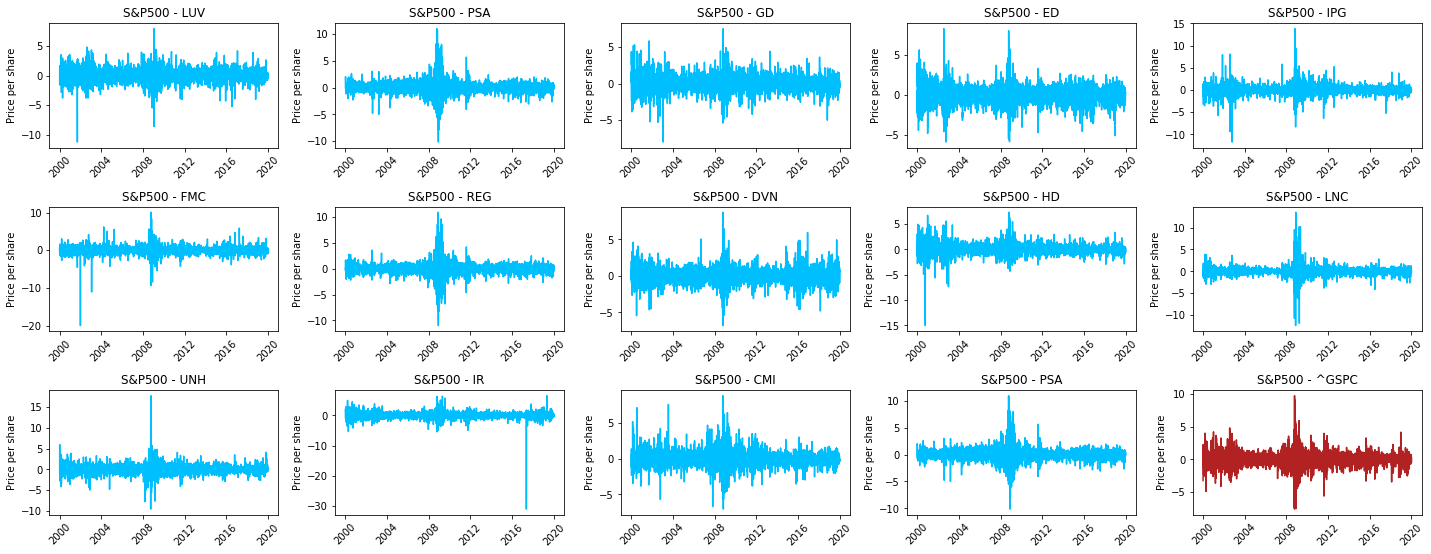

In [7]:
# Make the layout
n_rows = 6
n_cols = 5

plt.figure(figsize = (20,15))
for i,stock in enumerate(stocks_to_plot):
    # Choose the color
    if stock == '^GSPC':
        color = 'firebrick'
    else:
        color = 'deepskyblue'

    # Plot the stock prices
    plt.subplot(n_rows, n_cols, i + 1)
    sns.lineplot(x = df_stand.index, y = df_stand[stock], color = color)

    # Formatting
    plt.title('S&P500 - {}'.format(stock))
    plt.xlabel('')
    plt.ylabel('Price per share')
    plt.xticks(rotation = 45)

# Formatting
plt.tight_layout()
plt.show()

we can expect that we have eliminated the autocorrelation of each series.

## Creation of train and test sets

Once the data is preprocessed, we have to split it into a training set, to develop our PCA approach to eigen-portfolios, and a test set, to test the performance of this approach to generate an optimal portfolio.

In [8]:
# Choose a data for split the data
date_split = pd.to_datetime('2015-01-01', format = '%Y-%m-%d')

# Create train and test sets
df_stand_train = df_stand[df_returns.index <= date_split].copy()
df_stand_test  = df_stand[df_returns.index >  date_split].copy()

df_train = df_returns[df_returns.index <= date_split].copy()
df_test  = df_returns[df_returns.index >  date_split].copy()

# Split the DJI index from the stocks
X_stand_train = df_stand_train.drop('^GSPC', axis = 1)
y_stand_train = df_stand_train[['^GSPC']]

X_stand_test = df_stand_test.drop('^GSPC', axis = 1)
y_stand_test = df_stand_test[['^GSPC']]

X_test = df_test.drop('^GSPC', axis = 1)
y_test = df_test[['^GSPC']]

## Principal Component Analysis

PCA is defined as an orthogonal linear transformation that transforms the data from the original coordinate system with $\{X_i\}_{i=1}^D$ to a new coordinate system $\{Z_i\}_{i=1}^{D'}$, usually with $D' < D$, with 

$$ Z = X W \Longleftrightarrow X = Z W^T $$

where $W$ is the $D \times D'$ weight matrix of the transformation, which we assume to be orthogonal, that is, satisfying $WW^T = I$. This transformation is done in such a way that the greatest variance of the data comes to lie on the first coordinate $Z_1$ (called the first principal component), the second greatest variance on the second coordinate $Z_2$, and so on. Since the total variance of $X$, make out of $N$ samples, can be computed as

\begin{align*}
    & Var(X) = \frac{1}{N - 1} Tr(X^T X) = Tr(C) = Tr(V \Lambda V^T) = Tr(\Lambda) = \sum_{i=1}^D \lambda_i
\end{align*}

where $C$ is the covariance matrix, which can be diagonalized to the matrix $\Lambda$ using a eigenvalue decomposition. Then, $\{\lambda_i\}_{i=1}^{D}$ denote the eigenvalues of $C$, and $V$ is the matrix whose columns denote the eigenvectors of $C$. So, computing the variance of $Z$, 

\begin{align*} 
    & Var(Z) = \frac{1}{N - 1} Tr(Z^T Z)  = \frac{1}{N - 1} Tr(W^T X^T X W) = Tr(W^T C W) = Tr(W^T V \Lambda V^T W) = Tr(\Lambda) = \sum_{i=1}^D \lambda_i
\end{align*}

we can see that the total variance is conserved in the new projection if we choose $W = V$. This will provide by definition a projection to an orthogonal space, since the vectors of the basis the new space, the eigenvectors contained in $V$, form a orthogonal basis.

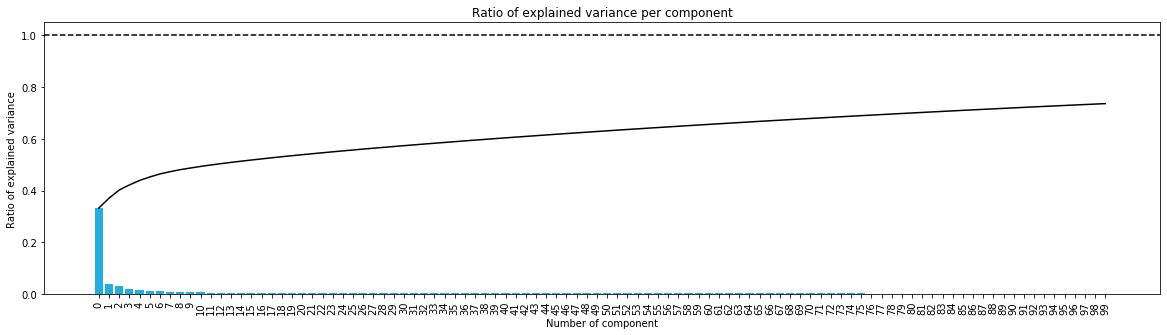

In [9]:
# Train PCA model
pca = PCA(n_components = 100)
pca.fit(X_stand_train)

# Plot the variance explained by each principal component
var_explained = pca.explained_variance_ratio_
var_explained_cum = np.cumsum(var_explained)

# Make the plot
plt.figure(figsize = (20,5))
sns.barplot(x = np.arange(var_explained.shape[0]), y = var_explained, color = 'deepskyblue')
sns.lineplot(x = np.arange(var_explained.shape[0]), y = var_explained_cum, color = 'black')
plt.axhline(y = 1.0, linestyle = '--',color = 'black')
plt.title('Ratio of explained variance per component')
plt.xlabel('Number of component')
plt.ylabel('Ratio of explained variance')
plt.xticks(rotation = 90)
plt.show()

We can see that the majority of the variance is contained in the firsts principal components.

## Eigen-portfolio construction

As we said, the eigenvectors of the covariance matrix provide the weights to a new space in which the coordinates are orthogonal to each other. In this project, each coordinate represents a stock, so the new coordinates will represent portfolios of stocks, denoted as eigen-portfolios, which combine them in a certain proportion given by these weights. Following \[1\] we define the weight of the stock $i$ in the eigen-portfolio $j$ as:

$$ Q_i^{(j)} = \frac{v_i^{(j)}}{\sigma_i} $$

where $v_i$ represents the $i$-th element of $j$-th eigen vector, that is, the presence of the stock $i$ in the $j$ eigen-portfolio, and $\sigma_i$ represents the volatiliy of the stock $i$.

In [13]:
# Obtain the eigenvectors of the covariance matrix
v = pca.components_.T

# Compute the eigenportfolio weights
eigenportfolios = pd.DataFrame({i : v[:,i] / df_volatility[i] for i in range(v.shape[1]) }, index = X_stand_train.columns.tolist())

# Normalize them
eigenportfolios = eigenportfolios/ eigenportfolios.sum()

Each portfolio will describe some proportion of the variance of the market. Specifically, since the first eigen-porfolio will explain the majority of this variance, we can expect it to reproduce the evolution of the market, which in our case is described by the evolution of the S&P 500 index. Taking a look to the firsts eigen-porfolios:

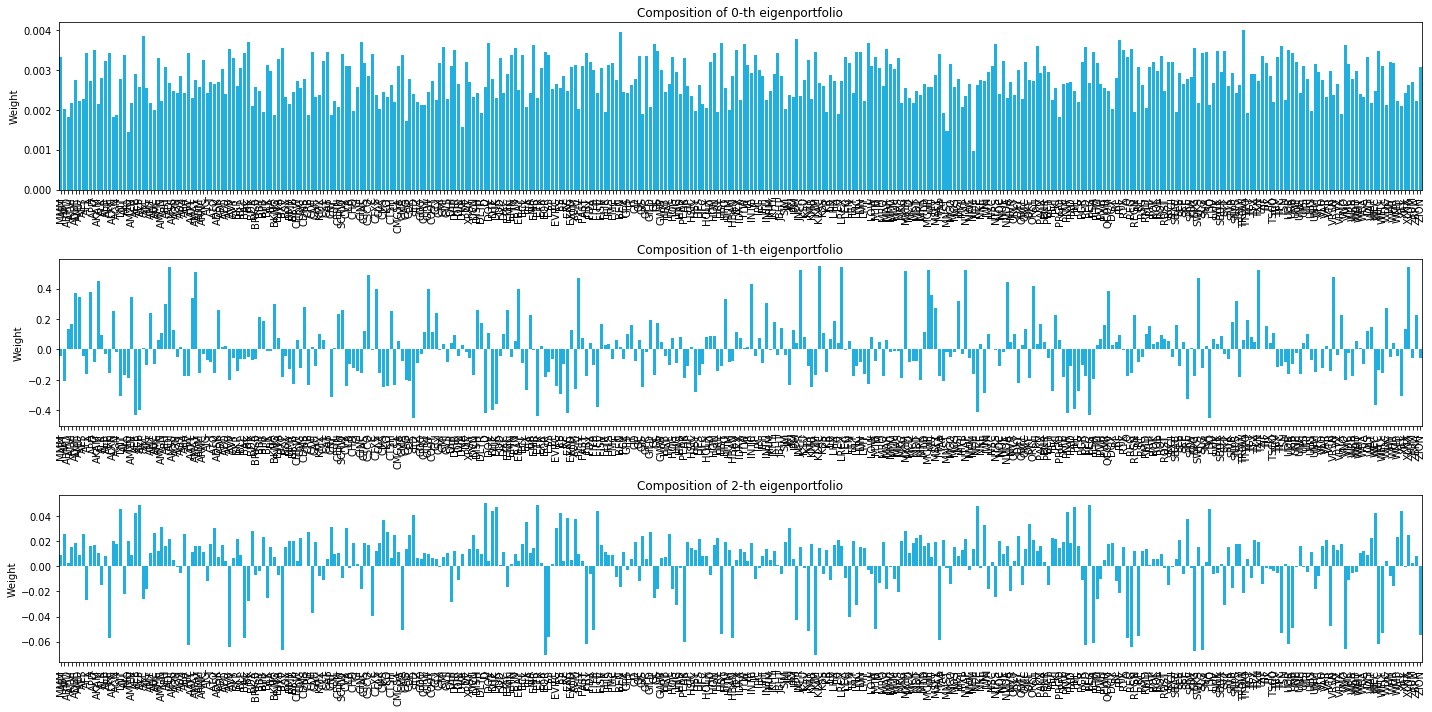

In [14]:
# Make the layout
n_rows = 3
n_cols = 1

plt.figure(figsize=(20,10))
for i in range(n_rows * n_cols):
    # Make the plot
    plt.subplot(n_rows, n_cols, i + 1)
    sns.barplot(x = eigenportfolios.index, y = eigenportfolios[i], color = 'deepskyblue')

    # Formatting
    plt.title('Composition of {}-th eigenportfolio'.format(i))
    plt.xlabel('')
    plt.ylabel('Weight')
    plt.xticks(rotation = 90)

# Formatting
plt.tight_layout()
plt.show()

we can see that the first eigen-portfolio have all its componets with a positive weight, as we expected, and the rest ones have very diverse compositions.

## Computation of Sharpe ratio

In finance, the Sharpe ratio measures the performance of an investment compared to a risk-free asset, after adjusting for its risk. It is defined as the difference between the returns of the investment and the risk-free return, divided by the standard deviation of the investment, that is, its volatility. It represents the additional amount of return that an investor receives per unit of increase in risk, that is, how well the return of an asset compensates the investor for the risk taken. It was named after William F. Sharpe, who developed it in 1966 \[2\].

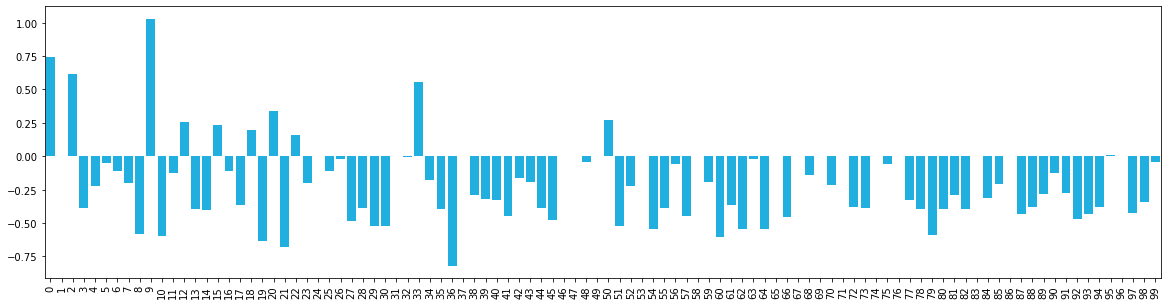

In [18]:
# Initalize a empty list
sharpe_ratios = []

# Copute Sharpe ratio for all portfolios
for i in range(eigenportfolios.shape[1]):
    # Compute the portfolio returns
    portfolio_returns = pd.Series(np.dot(X_test, eigenportfolios[i]), index=X_test.index)

    # Compute the Sharpe ratio
    periods_per_year = 252
    n_years = portfolio_returns.shape[0] / periods_per_year
    annualized_returns = np.power(np.prod(1 + portfolio_returns), 1/n_years)
    annualized_volatility = portfolio_returns.std() * np.sqrt(periods_per_year)
    sharpe = (annualized_returns - 1) / annualized_volatility

    # Avoid numerical inestabilities
    if sharpe > 100 or sharpe < -100 or sharpe == np.nan:
        sharpe = 0

    # Append the value to the list
    sharpe_ratios.append(sharpe)

# Sort the porfolios by its shape ratios
sharpe_ratios = np.nan_to_num(sharpe_ratios)
best_portfolios = np.argsort(sharpe_ratios)[::-1]

# Take a look them
plt.figure(figsize = (20,5))
sns.barplot(x = np.arange(eigenportfolios.shape[1]), y = sharpe_ratios, color = 'deepskyblue')
plt.xticks(rotation = 90)
plt.show()

So no, we can find the portfolio with the highest sharpe ratio, that is, the portfolio with the best relation between returns and volatility, and compare its evolution with the market, represented by the S&P 500 index

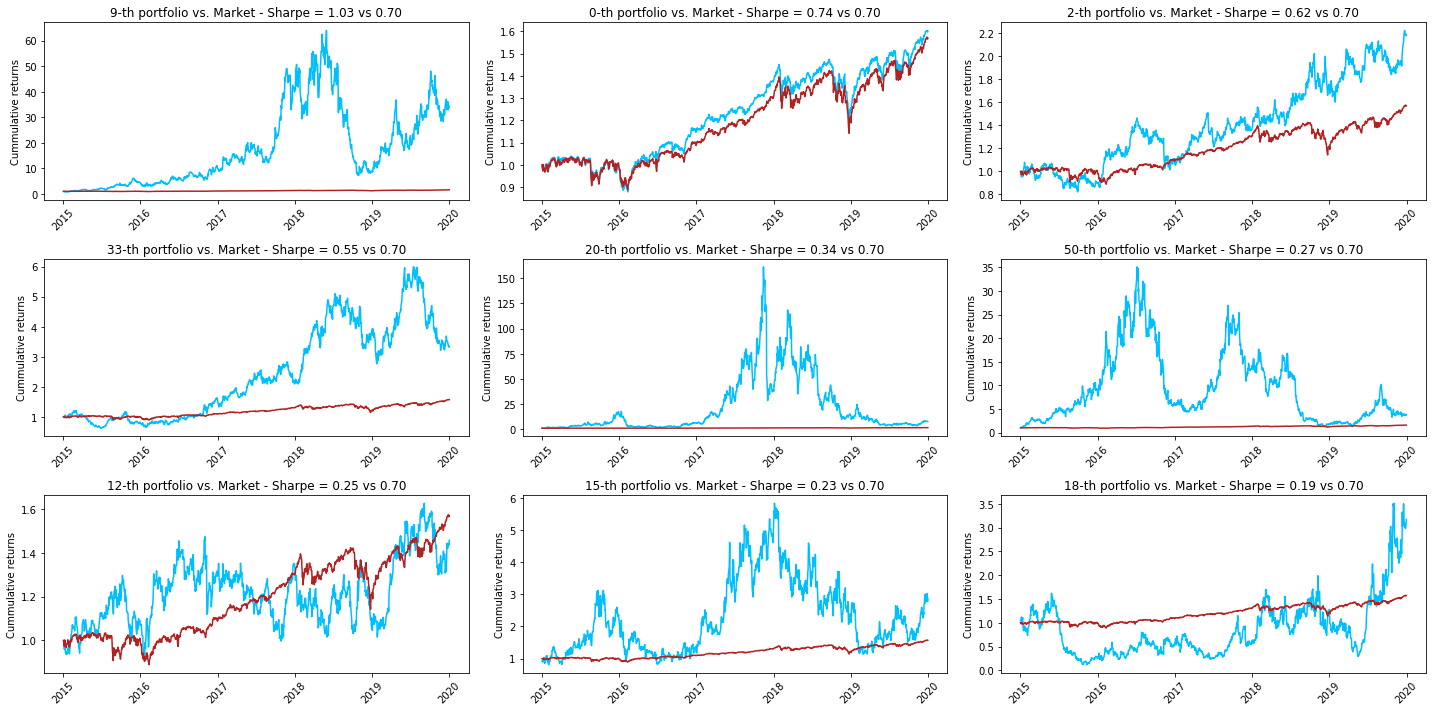

In [21]:
# Make the layout
n_rows = 3
n_cols = 3

plt.figure(figsize=(20,10))
for i in range(n_rows * n_cols):
    # Compute the portfolio returns and cummulative returns
    portfolio_returns = pd.Series(np.dot(X_test, eigenportfolios[best_portfolios[i]]), index=X_test.index)
    portfolio_cum_returns = np.cumprod(portfolio_returns + 1)
    
    # Compute the market returns and cummulative returns
    market_returns = np.squeeze(y_test)
    market_cum_returns = np.cumprod(market_returns + 1)

    # Compute the Sharpe ratio
    periods_per_year = 252
    n_years = portfolio_returns.shape[0] / periods_per_year

    annualized_returns = np.power(np.prod(1 + portfolio_returns), 1/n_years)
    annualized_volatility = portfolio_returns.std() * np.sqrt(periods_per_year)
    sharpe_portfolio = (annualized_returns - 1) / annualized_volatility

    annualized_returns = np.power(np.prod(1 + market_returns), 1/n_years)
    annualized_volatility = market_returns.std() * np.sqrt(periods_per_year)
    sharpe_market = (annualized_returns - 1) / annualized_volatility

    # Make the plot
    plt.subplot(n_rows, n_cols, i + 1)
    sns.lineplot(x = X_test.index, y = portfolio_cum_returns, color = 'deepskyblue')
    sns.lineplot(x = X_test.index, y = market_cum_returns, color = 'firebrick')
    plt.title('{}-th portfolio vs. Market - Sharpe = {:.2f} vs {:.2f}'.format(best_portfolios[i], sharpe_portfolio, sharpe_market))
    plt.xlabel('')
    plt.ylabel('Cummulative returns')
    plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()